In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid
#from google.colab import files

In [111]:
file_name = "BTCUSDT_1D_alan.csv"

In [112]:
fd = pd.read_csv(file_name)
fd['Entry_Price_L'] = np.nan
fd['Entry_Price_S'] = np.nan
fd['pnl_L'] = ''
fd['pnl_S'] = ''

if "1D" in file_name:
    no_of_hours = 24
elif "8H" in file_name:
    no_of_hours = 8
elif "4H" in file_name:
    no_of_hours = 4
elif "1H" in file_name:
    no_of_hours = 1




In [113]:
first_row_index = fd["SentimentScore"].dropna().index[0]
last_row_index = fd["SentimentScore"].dropna().index[-1]
fd = fd[first_row_index:last_row_index+1]
fd = fd.reset_index(drop=True)
#fd.set_index("Open Time", inplace=True)
fd.tail()

,Open Time,Open,High,Low,Close,Volume,SentimentScore,Entry_Price_L,Entry_Price_S,pnl_L,pnl_S
108,25/3/2023,27454.46,27787.33,27156.09,27462.95,50844.08102,0.271130,NaN,NaN,,
109,26/3/2023,27462.96,28194.40,27417.76,27968.05,49671.70353,0.247773,NaN,NaN,,
110,27/3/2023,27968.05,28023.86,26508.14,27124.91,88039.46898,0.259900,NaN,NaN,,
111,28/3/2023,27124.90,27520.00,26631.78,27261.07,78602.44341,0.231054,NaN,NaN,,
112,29/3/2023,27261.06,28650.00,27240.10,28348.60,89486.16008,0.531616,NaN,NaN,,


In [114]:
Q1 = fd['SentimentScore'].quantile(0.25)
Q2 = fd['SentimentScore'].quantile(0.5)  # This is also the median
Q3 = fd['SentimentScore'].quantile(0.75)

print(f"1st Quartile (Q1): {Q1}")
print(f"2nd Quartile (Q2) / Median: {Q2}")
print(f"3rd Quartile (Q3): {Q3}")

1st Quartile (Q1): 0.20925637225000002
2nd Quartile (Q2) / Median: 0.300769627
3rd Quartile (Q3): 0.41723093975000003


In [115]:
bull_param = 0.3
bear_param = -0.3
holding_period = 3
hold_date_L = np.nan  #date count for a Long position
hold_date_S = np.nan  #date count for a Short position
take_profit = 0.1
stop_loss = -0.2

In [151]:
def trading(fd_original, bull_param, bear_param, holding_period, hold_date_L, hold_date_S, take_profit,stop_loss):
  fd  = fd_original.copy()
  #long
  for index,row in fd.iterrows() :
    if row['SentimentScore'] >= bull_param and pd.isna(hold_date_L) == True :
    #if row['Sentiment'] >= 0.711 and row['Sentiment'] <= 0.712 :
      if pd.isna(row['Entry_Price_L']) == True :
        fd.loc[index, ['Entry_Price_L']] = row['Close']
        hold_date_L = 0
      continue
  
    if fd.iloc[index-1]['Entry_Price_L'] > 0 and pd.isna(hold_date_L) == False :

      if fd.iloc[index-1]['Entry_Price_L'] * (1 + take_profit) < fd.iloc[index]['High'] :   ## Take Profit condition
        fd.loc[index, 'Entry_Price_L'] = row['Close']
        fd.loc[index, 'pnl_L'] = (fd.loc[index, 'Entry_Price_L'] / fd.loc[index-1, 'Entry_Price_L']) - 1
        hold_date_L = np.nan
        continue

      if fd.iloc[index-1]['Entry_Price_L'] * (1 + stop_loss) > fd.iloc[index]['Low'] :      ## Stop Loss condition
        fd.loc[index, 'Entry_Price_L'] = row['Close']
        fd.loc[index, 'pnl_L'] = (fd.loc[index, 'Entry_Price_L'] / fd.loc[index-1, 'Entry_Price_L']) - 1
        hold_date_L = np.nan
        continue

      if hold_date_L < holding_period :
        fd.loc[index,'Entry_Price_L'] = fd.iloc[index-1]['Entry_Price_L']
        hold_date_L += 1
      if hold_date_L == holding_period :
        fd.loc[index, 'Entry_Price_L'] = row['Close']
        fd.loc[index, 'pnl_L'] = (fd.loc[index, 'Entry_Price_L'] / fd.loc[index-1, 'Entry_Price_L']) - 1
        hold_date_L = np.nan

    if row['Open Time'] == fd.iloc[-1]['Open Time'] and pd.isna(hold_date_L) == False :
      hold_date_L = np.nan
      fd.loc[index, 'Entry_Price_L'] = row['Close']
      fd.loc[index, 'pnl_L'] = (fd.loc[index, 'Entry_Price_L'] / fd.loc[index-1, 'Entry_Price_L']) - 1

  #short
  for index,row in fd.iterrows() :

    if row['SentimentScore'] <= bear_param and pd.isna(hold_date_S) == True :
      if pd.isna(row['Entry_Price_S']) == True :
        fd.loc[index, ['Entry_Price_S']] = row['Close']
        hold_date_S = 0
      continue

    if fd.iloc[index-1]['Entry_Price_S'] > 0 and pd.isna(hold_date_S) == False :

      if fd.iloc[index-1]['Entry_Price_S'] * (1 + (-1)*take_profit) > fd.iloc[index]['Low'] :   ## Take Profit condition
        fd.loc[index, 'Entry_Price_S'] = row['Close']
        fd.loc[index, 'pnl_S'] = ((fd.loc[index, 'Entry_Price_S'] / fd.loc[index-1, 'Entry_Price_S']) - 1) * (-1)
        hold_date_S = np.nan
        continue

      if fd.iloc[index-1]['Entry_Price_S'] * (1 + (-1)*stop_loss) < fd.iloc[index]['High'] :      ## Stop Loss condition
        fd.loc[index, 'Entry_Price_S'] = row['Close']
        fd.loc[index, 'pnl_S'] = ((fd.loc[index, 'Entry_Price_S'] / fd.loc[index-1, 'Entry_Price_S']) - 1) * (-1)
        hold_date_S = np.nan
        continue

      if hold_date_S < holding_period :
        fd.loc[index,'Entry_Price_S'] = fd.iloc[index-1]['Entry_Price_S']
        hold_date_S += 1
      if hold_date_S == holding_period :
        fd.loc[index, 'Entry_Price_S'] = row['Close']
        fd.loc[index, 'pnl_S'] = ((fd.loc[index, 'Entry_Price_S'] / fd.loc[index-1, 'Entry_Price_S']) - 1) * (-1)
        hold_date_S = np.nan

    if row['Open Time'] == fd.iloc[-1]['Open Time'] and pd.isna(hold_date_S) == False :
      hold_date_S = np.nan
      fd.loc[index, 'Entry_Price_S'] = row['Close']
      fd.loc[index, 'pnl_S'] = (fd.loc[index, 'Entry_Price_S'] / fd.loc[index-1, 'Entry_Price_S']) - 1
  
  return fd

def evaluation(df_orignial, risk_free_rate_annual, hours_per_period, initial_capital):
  df= df_orignial.copy()
  df.set_index('Open Time', inplace=True)
  
  # Calculate Total P&L
  df.loc[df['pnl_S'] == '', 'pnl_S'] = np.nan
  df.loc[df['pnl_L'] == '', 'pnl_L'] = np.nan
  df['total_pnl'] = df['pnl_L'].fillna(0) + df['pnl_S'].fillna(0)

  #Caculate Equity
  df['Equity'] = (1 + df['total_pnl'].fillna(0)).cumprod() * initial_capital


  #Calculate Return
  return_performance = (df['Equity'][-1]/df['Equity'][0] - 1)*100

  # Calculate Win rate
  trade_df = df["total_pnl"].dropna()
  no_of_win = trade_df[trade_df > 0].shape[0]
  no_of_lose = trade_df[trade_df < 0].shape[0]
  no_of_trade = no_of_win + no_of_lose
  win_rate = (no_of_win / no_of_trade) * 100
  
  # Drawdown
  df['Running Max'] = df['Equity'].cummax()
  df['Drawdown'] = df['Running Max'] - df['Equity']
  max_drawdown = df['Drawdown'].max()
  max_drawdown_percentage = df['Drawdown'].max() / df['Running Max'].max() * 100


  # Sharpe ratio
  sharpe_ratio_adjusted = sharpe_ratio_calculation(df, risk_free_rate_annual, hours_per_period)

  
  # Simulate BTC trend
  df['BTC'] = (1 + df['Close'].pct_change()).cumprod() * initial_capital
  df['BTC'][0] = 1

  #BTC drawndown, return, sharpe
  #btc return
  btc_return_performance = (df['Close'][-1]/df['Close'][0] - 1)*100

  #btc draw down
  df['btc_Running Max'] = df['BTC'].cummax()
  df['btc_Drawdown'] = df['btc_Running Max'] - df['BTC']
  btc_max_drawdown = df['btc_Drawdown'].max()
  btc_max_drawdown_percentage = df['btc_Drawdown'].max() / df['btc_Running Max'].max() * 100

  #btc sharpe
  btc_sharpe = btc_sharpe_cal(hours_per_period, risk_free_rate_annual, df)
 

  #plot graph
  plot_chart(df, initial_capital)

  # Print outputs
  print(f"Strategy Return: {return_performance:.2f}%")
  print(f"No. of trade: {no_of_trade}")
  print(f"No. of winning trade: {no_of_win}")
  print(f"Win Rate: {win_rate:.2f}%")
  print(f"Maximum Drawdown: {max_drawdown_percentage:.2f}%")
  print(f"Annualized Sharpe Ratio: {sharpe_ratio_adjusted:.2f}")
  print("=====================================")
  print(f"BTC Return: {btc_return_performance:.2f}%")
  print(f"Maximum Drawdown: {btc_max_drawdown_percentage:.2f}%")
  print(f"Annualized Sharpe Ratio: {btc_sharpe:.2f}")



def sharpe_ratio_calculation(df_original, risk_free_rate_annual, hours_per_period):
  df = df_original.copy()
  # Calculate 'total_pnl'
  df.loc[df['pnl_S'] == '', 'pnl_S'] = np.nan
  df.loc[df['pnl_L'] == '', 'pnl_L'] = np.nan
  df['total_pnl'] = df['pnl_L'].fillna(0) + df['pnl_S'].fillna(0)
  # Calculate 'Equity'
  initial_capital = 1

  df['Equity'] = (1 + df['total_pnl'].fillna(0)).cumprod() * initial_capital
  periods_per_day = 24 / hours_per_period
  trading_days_per_year = 365
  periods_per_year = periods_per_day * trading_days_per_year

  # Calculate the risk-free rate per period
  risk_free_rate_per_period = (1 + risk_free_rate_annual) ** (1 / periods_per_year) - 1

  # DataFrame Calculations
  df['period_returns'] = df['Equity'].pct_change()

  average_return_per_period = df['period_returns'].mean()
  std_dev_per_period = df['period_returns'].std()

  # Adjusted Sharpe Ratio
  sharpe_ratio_adjusted = (average_return_per_period - risk_free_rate_per_period) / std_dev_per_period * (periods_per_year ** 0.5)

  return sharpe_ratio_adjusted

def optimize_sharpe(param_grid, df_original, risk_free_rate_annual, hours_per_period):

  # Initialize variables to store the best parameters
  best_sharpe_ratio = -np.inf
  best_params = None
  df = df_original.copy()
  # Grid search
  for params in ParameterGrid(param_grid):
      trading_result = trading(df, **params, hold_date_L= np.nan, hold_date_S = np.nan)
      sharpe_ratio = sharpe_ratio_calculation(trading_result, risk_free_rate_annual, hours_per_period = hours_per_period)

      if sharpe_ratio > best_sharpe_ratio:
          best_sharpe_ratio = sharpe_ratio
          best_params = params
          best_result = trading_result.copy()


    # Print the best parameters
  print(f"Best Sharpe Ratio: {best_sharpe_ratio}")
  print("best params: ", best_params)

  return best_result, best_params

def plot_chart(df, initial_capital):
  #df.to_csv("final_check.csv")
  # Simulate BTC trend
  df['BTC'] = (1 + df['Close'].pct_change()).cumprod() * initial_capital
  df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
  #df.set_index("Open Time", inplace = True)
  # Plot Equity curve with BTC trend
  plt.figure(figsize=(10, 6))
  plt.plot(df.index, df['Equity'], marker='', linestyle='-', markersize=4, label='Equity')
  plt.plot(df.index, df['BTC'], marker='', linestyle='-', markersize=4, label='BTC-USD')
  plt.title('Equity Curve')
  plt.xlabel('Open Time')
  plt.ylabel('Equity')
  plt.legend()
  plt.grid(True)

  # Customizing the x-axis to show monthly ticks
  ax = plt.gca()  # Get the current Axes instance
  ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to monthly
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format major ticks as 'Year-Month'


  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

def btc_sharpe_cal(hours_per_period, risk_free_rate_annual, df):
  periods_per_day = 24 / hours_per_period
  trading_days_per_year = 365
  periods_per_year = periods_per_day * trading_days_per_year

  # Calculate the risk-free rate per period
  risk_free_rate_per_period = (1 + risk_free_rate_annual) ** (1 / periods_per_year) - 1

  # DataFrame Calculations
  df['btc_period_returns'] = df['BTC'].pct_change()
  average_return_per_period = df['btc_period_returns'].mean()
  std_dev_per_period = df['btc_period_returns'].std()

  # Adjusted Sharpe Ratio
  sharpe_ratio_adjusted = (average_return_per_period - risk_free_rate_per_period) / std_dev_per_period * (periods_per_year ** 0.5)

  return sharpe_ratio_adjusted

# Backtest and evaluation

In [142]:
risk_free_rate_annual = 0.03

# Train Test Split

In [143]:
train_size = int(len(fd) * 0.8)
train_set = fd[:train_size]
test_set = fd[train_size:]

train_set.shape, test_set.shape

((90, 11), (23, 11))

# Optimization for training set

In [144]:
# Define the parameter grid
param_grid = {
    'bull_param': np.arange(0.3, 1, 0.1),
    'bear_param': np.arange(-0.5, 0.3, 0.1),
    'holding_period': range(2, 6),  # From 2 to 6
    'take_profit': np.arange(0.03, 0.1, 0.05),
    'stop_loss': np.arange(-0.03, -0.1, -0.05)
}

#df = pd.read_csv("demo.csv")

In [145]:
best_result = optimize_sharpe(param_grid, train_set , risk_free_rate_annual, hours_per_period=no_of_hours)

Best Sharpe Ratio: 4.4819239370583475
best params:  {'bear_param': -1.1102230246251565e-16, 'bull_param': 0.4, 'holding_period': 4, 'stop_loss': -0.08, 'take_profit': 0.03}


C:\Users\FaiChung\AppData\Local\Temp\ipykernel_13628\1627575708.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BTC'][0] = 1


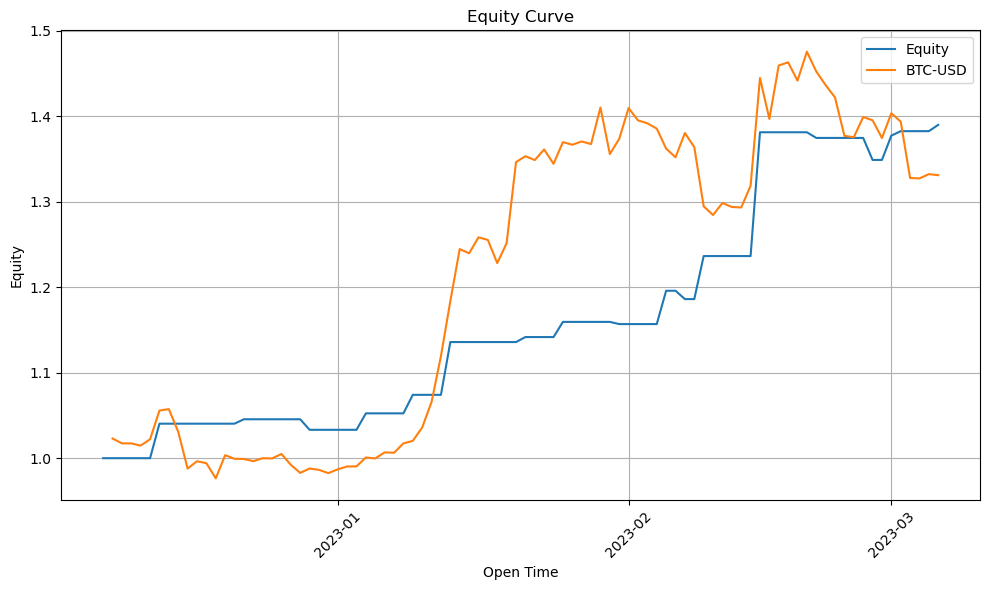

Strategy Return: 38.99%
No. of trade: 18
No. of winning trade: 13
Win Rate: 72.22%
Maximum Drawdown: 2.33%
Annualized Sharpe Ratio: 4.48
BTC Return: 33.10%
Maximum Drawdown: 10.05%
Annualized Sharpe Ratio: 2.80


In [152]:
evaluation(best_result[0], risk_free_rate_annual, hours_per_period= no_of_hours, initial_capital=1)

# Test set

In [147]:
bull_param = best_result[1]["bull_param"]
bear_param = best_result[1]["bear_param"]
holding_period = best_result[1]["holding_period"]
take_profit = best_result[1]["take_profit"]
stop_loss = best_result[1]["stop_loss"]
test_set_reset = test_set.reset_index(drop=True)

In [148]:
test_traded = trading(test_set_reset, bull_param, bear_param, holding_period, hold_date_L, hold_date_S, take_profit,stop_loss)

C:\Users\FaiChung\AppData\Local\Temp\ipykernel_13628\2976573442.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BTC'][0] = 1


Index(['7/3/2023', '8/3/2023', '9/3/2023', '10/3/2023', '11/3/2023',
       '12/3/2023', '13/3/2023', '14/3/2023', '15/3/2023', '16/3/2023',
       '17/3/2023', '18/3/2023', '19/3/2023', '20/3/2023', '21/3/2023',
       '22/3/2023', '23/3/2023', '24/3/2023', '25/3/2023', '26/3/2023',
       '27/3/2023', '28/3/2023', '29/3/2023'],
      dtype='object', name='Open Time')


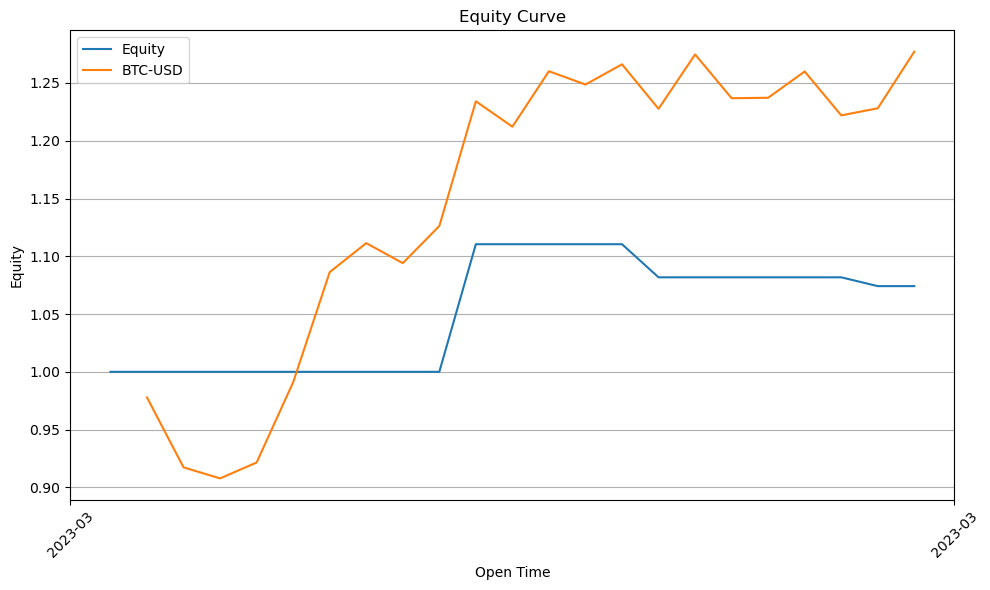

Strategy Return: 7.42%
No. of trade: 3
No. of winning trade: 1
Win Rate: 33.33%
Maximum Drawdown: 3.27%
Annualized Sharpe Ratio: 2.68
BTC Return: 27.71%
Maximum Drawdown: 7.22%
Annualized Sharpe Ratio: 5.52


In [149]:
evaluation(test_traded , risk_free_rate_annual, hours_per_period= no_of_hours, initial_capital=1)

In [150]:
checking = trading(fd, bull_param, bear_param, holding_period, hold_date_L, hold_date_S, take_profit,stop_loss)


In [ ]:
#this is a change ta 20:57

,Open Time,Open,High,Low,Close,Volume,SentimentScore,Entry_Price_L,Entry_Price_S,pnl_L,pnl_S
813,25/3/2023,27454.46,27787.33,27156.09,27462.95,50844.08102,0.271130,28295.41,NaN,,
814,26/3/2023,27462.96,28194.40,27417.76,27968.05,49671.70353,0.247773,27968.05,NaN,-0.011569,
815,27/3/2023,27968.05,28023.86,26508.14,27124.91,88039.46898,0.259900,NaN,NaN,,
816,28/3/2023,27124.90,27520.00,26631.78,27261.07,78602.44341,0.231054,NaN,NaN,,
817,29/3/2023,27261.06,28650.00,27240.10,28348.60,89486.16008,0.531616,28348.60,NaN,,


In [ ]:
#new branch 21:16